In [1]:
import numpy as np 
import pandas as pd
import re
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
from sklearn.model_selection import train_test_split
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# фиксируем, чтобы наши эксперименты были воспроизводимы!
RANDOM_SEED = 42
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'sample_submission.csv')

# для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

# анализируем Number_of_Reviews
# вытащим из столбца Reviews даты посещений и добавим 2 столбца посещений (да / нет), 
# перевод дат в реальные даты, добавление столбца с разницей дат результаты модели ухудшили, пришлось отказаться
def isNaN(string):
    return string != string
def review_parser_date_1(string):
    if isNaN(string) != True:
        dates = re.findall(r'\d\d\/\d\d\/\d{4}', string[1:-1])
        if(len(dates) == 2):
            return int(1)
        elif(len(dates) == 1):
            return int(1)
def review_parser_date_2(string):
    if isNaN(string) != True:
        dates = re.findall(r'\d\d\/\d\d\/\d{4}', string[1:-1])
        if(len(dates) == 2):
            return int(1)
df['date_1'] = df['Reviews'].apply(review_parser_date_1)
df['date_2'] = df['Reviews'].apply(review_parser_date_2)
# заполним столбец посещений единицей при наличии даты посещения, если нет даты, заполним потом нулями
def set_number_of_reviews(date):
    if(date == date):
        return 1
df['Number of Reviews'].fillna(df['date_1'].apply(set_number_of_reviews), inplace=True)
# добавляем столбец о наличии пропуска как отдельный признак
df['Number of Reviews isNAN'] = pd.isna(df['Number of Reviews']).astype('uint8')
# и заполняем нулями NaN
df['Number of Reviews'].fillna(0, inplace=True)

# добавляем столбец о наличии пропуска как отдельный признак
df['Price Range isNAN'] = pd.isna(df['Price Range']).astype('uint8')
# заполняем средним значением столбец Price Range
df['Price Range'].fillna('$$ - $$$', inplace = True)
# и закодируем признка как '$$ - $$$' - 50 '$$$$' - 100 '$' - 20
def price_convert(price):
    if price == '$$ - $$$':
        return 50
    elif price == '$$$$':
        return 100
    else:
        return 20
df['Price Range'] = df['Price Range'].apply(price_convert)
# разберемся со столбцом City - можно было использовать pd.get_dummies, но для собственного понимая сделал в ручную
def find_city(cell):
    if city in cell:
        return 1
    else:
        return 0
city_set = set()
for city in df['City']:
    city_set.add(city)
for city in city_set:
    df[city] = df['City'].apply(find_city)
# добавляем столбец о наличии пропуска как отдельный признак
df['City isNAN'] = pd.isna(df['City']).astype('uint8')
# и аналогично с Cuisine Style, только взял 100 наиболее популярных типов, для пустых взял наиболее популяиный тип European
import ast
# добавляем столбец о наличии пропуска как отдельный признак
df['Cuisine Style isNAN'] = pd.isna(df['Cuisine Style']).astype('uint8')
df['Cuisine Style'] = df['Cuisine Style'].fillna('[\'European\']')
# создаем список типов 
styles = {}
for elements in df['Cuisine Style']:
    if elements == elements:
        x = ast.literal_eval(elements)
        arr = [n.strip() for n in x]
        for elem in arr:
            if styles.get(elem):
                styles[elem] += 1
            else:
                styles.setdefault(elem)
                styles[elem] = 1
# отбираем наиболее популярные 
opt_styles = set()
for style in styles:
    if styles[style] > 100:
        opt_styles.add(style)
# создаем столбцы по типам и заполняем их данными о принадлежности им
def find_cuisine(styles):
    if style in styles:
        return 1
    else:
        return 0
for style in opt_styles:
    df[style] = df['Cuisine Style'].apply(find_cuisine)

# модель дает MAE: 0.20957, если добавить столбы о наличии пропуска как отдельный признак,
# то модель дает MAE: 0.20933, осталяем. Наиболее важные признаки - Ranking и Number of Reviews

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


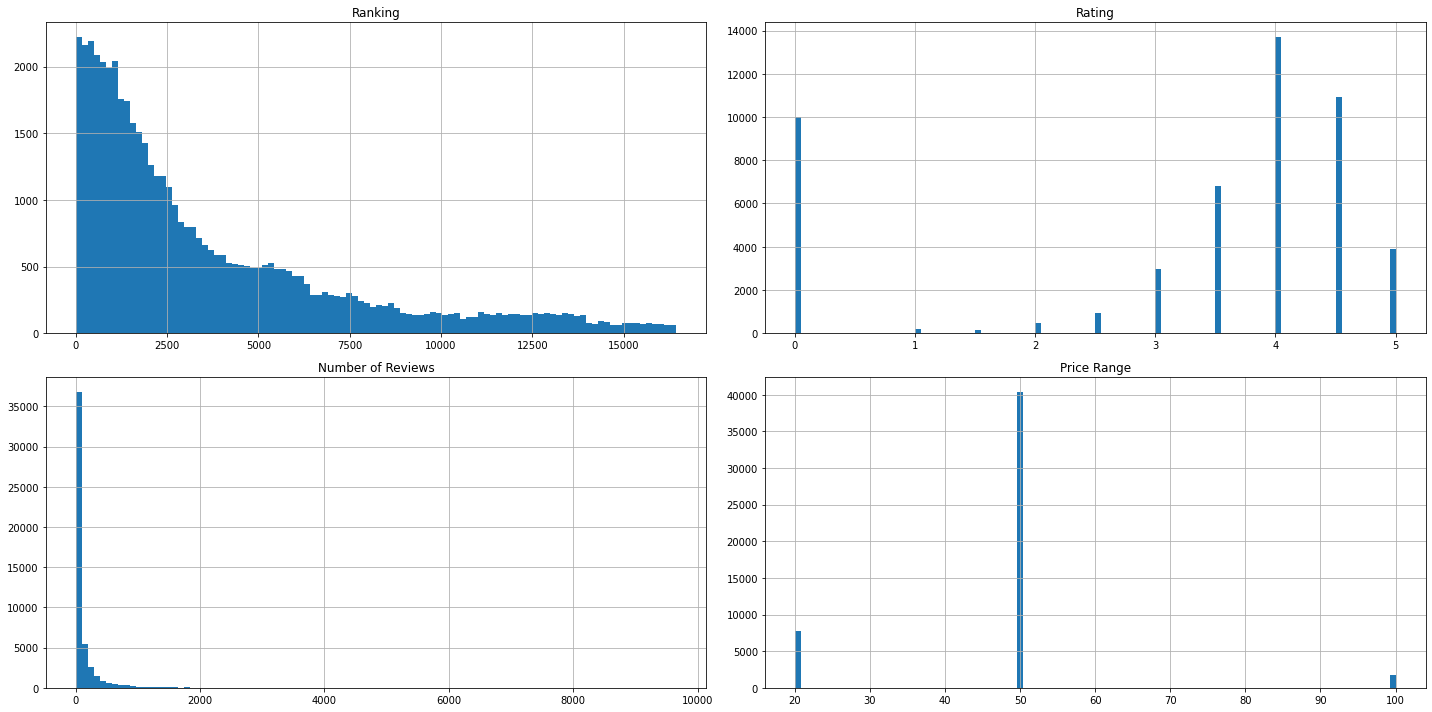

In [2]:
df[['Ranking', 'Rating', 'Number of Reviews','Price Range']].hist(figsize=(20, 10), bins=100);
plt.tight_layout()

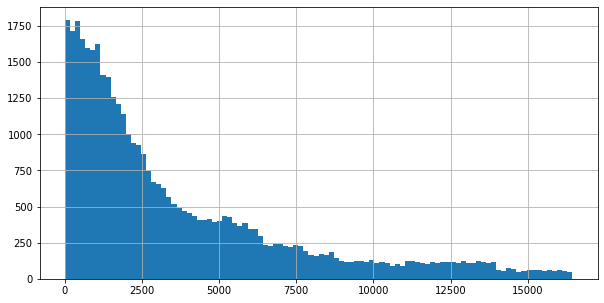

In [3]:
plt.rcParams['figure.figsize'] = (10,5)
df[df['sample'] == 1]['Ranking'].hist(bins=100);

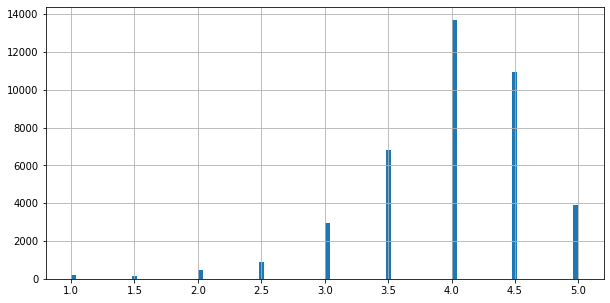

In [4]:
plt.rcParams['figure.figsize'] = (10,5)
df[df['sample'] == 1]['Rating'].hist(bins=100);

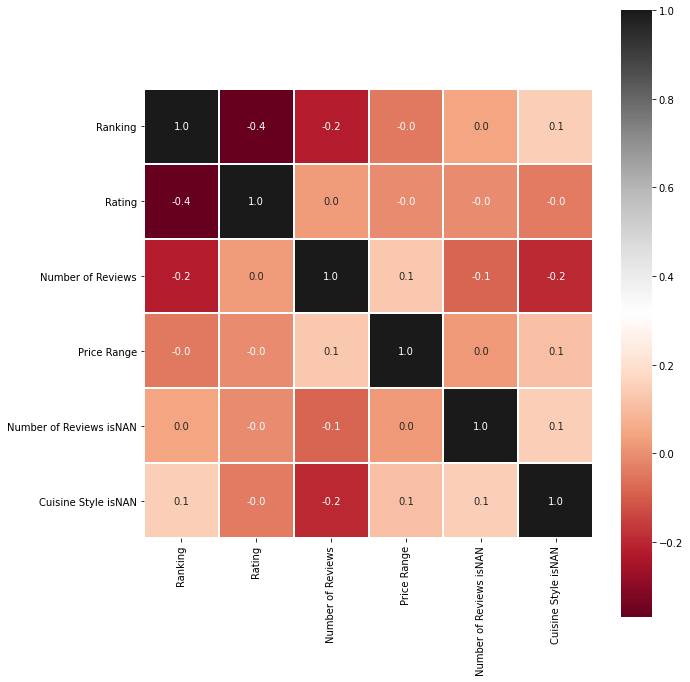

In [5]:
df_tmp = df[df['sample'] == 1][['Ranking', 'Rating', 'Number of Reviews', 'Price Range', 'Number of Reviews isNAN', 'Cuisine Style isNAN']].copy()
plt.rcParams['figure.figsize'] = (10, 10)
sns.heatmap(df_tmp.corr(), square=True, annot=True, fmt=".1f", linewidths=0.2, cmap="RdGy");
plt.tight_layout()

<AxesSubplot:>

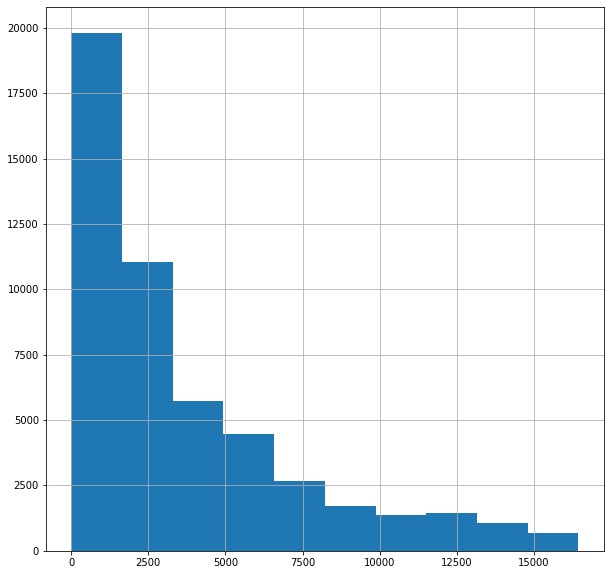

In [6]:
# посомотрим на столбецы повнимательнее
df['Ranking'].describe()
df['Ranking'].hist()

<AxesSubplot:>

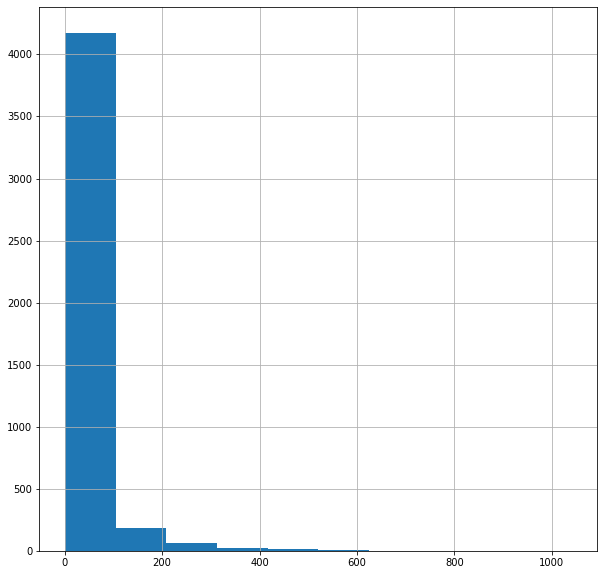

In [7]:
df.loc[df['Ranking'] > 10000]['Number of Reviews'].hist()

count      50000
unique        31
top       London
freq        7193
Name: City, dtype: object

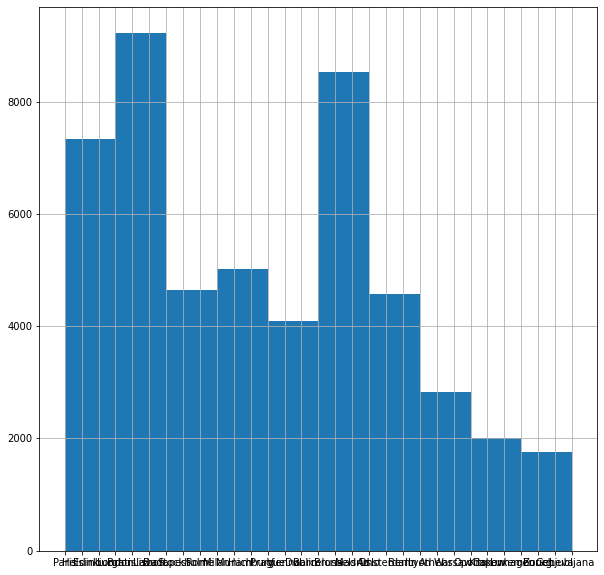

In [8]:
df['City'].hist()
df['City'].describe()

In [9]:
# посмотрим сколько ресторанов в городе
rest_in_city = df.groupby('City')['Ranking'].count().to_dict()
df['Restaurants in City'] = df['City'].map(rest_in_city)
# этот показатель дал MAE: 0.20759625, оставляем

In [10]:
# посмотрим на позицию ресторана отностительно всех ресторанов в городе
df['Rest Rank in City'] = df.apply(lambda x: round(x['Ranking']/x['Restaurants in City'],2), axis=1)
# этот показатель дал MAE: 0.206181875, оставляем

In [11]:
# и на позицию ресторана отностительно мин и макс рейтинга в городе
def get_rank(row):
    city_min = MinMax_Rank[MinMax_Rank['City'] == row.City ]['min'].iloc[0]
    city_max = MinMax_Rank[MinMax_Rank['City'] == row.City ]['max'].iloc[0]
    return round(1-(row['Ranking'] - city_min)/(city_max - city_min),2)
MinMax_Rank = df.groupby('City')['Ranking'].agg([min,max]).reset_index()
df['Min/Max Rank in City'] = df.apply(lambda x: get_rank(x), axis=1)
# этот показатель дал MAE: 0.20615375, оставляем

In [12]:
# столбцы date_1 и date_2 виде 0/1 не дали эффекта, попробуем заполнить реальными датами 
df.drop(['date_1', 'date_2'], axis = 1, inplace=True)
def review_date_1(string):
    if isNaN(string) != True:
        dates = re.findall(r'\d\d\/\d\d\/\d{4}', string[1:-1])
        if(len(dates) == 2):
            return datetime.strptime(dates[0], '%m/%d/%Y').timestamp()
        elif(len(dates) == 1):
            return datetime.strptime(dates[0], '%m/%d/%Y').timestamp()
def review_date_2(string):
    if isNaN(string) != True:
        dates = re.findall(r'\d\d\/\d\d\/\d{4}', string[1:-1])
        if(len(dates) == 2):
            return datetime.strptime(dates[1], '%m/%d/%Y').timestamp()
df['date_1'] = df['Reviews'].apply(review_date_1)
df['date_2'] = df['Reviews'].apply(review_date_2)
df['date_1'] = df['date_1'].fillna(datetime.timestamp(datetime(1970,1,1)))
df['date_2'] = df['date_2'].fillna(datetime.timestamp(datetime(1970,1,1)))

df['date_btw_reviews'] = abs(df['date_1'] - df['date_2'])/60/60/24
# этот показатель дал MAE: 0.204, а вот сами столбцы с датами в виде секунд не дали улучшения модели

In [13]:
df.head()
# тут очень был бы кстати анализ отзывов на положительные и отрицательные ключевые слов

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,African,Austrian,Spanish,Healthy,Restaurants in City,Rest Rank in City,Min/Max Rank in City,date_1,date_2,date_btw_reviews
0,id_0,Paris,"['Bar', 'Pub']",12963.0,50,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,...,0,0,0,0,6108,2.12,0.07,0.000000e+00,0.000000e+00,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,50,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,...,0,0,0,0,475,0.22,0.91,1.512432e+09,1.509235e+09,37.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,50,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,...,0,0,0,0,745,1.09,0.54,1.514419e+09,1.512518e+09,22.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,100,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,...,0,0,0,0,7193,0.23,0.90,1.512518e+09,1.511309e+09,14.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,100,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,...,0,0,0,0,380,0.10,0.96,1.518048e+09,1.516752e+09,15.0


In [14]:
# убираем не нужные для модели признаки
df['date_1'].fillna(0, inplace=True) 
df['date_2'].fillna(0, inplace=True)
df.drop(['Restaurant_id', 'City', 'Cuisine Style', 'Reviews', 'URL_TA', 'ID_TA', 'date_1', 'date_2'], axis = 1, inplace=True)
# 'date_1', 'date_2' не дали улучшения модели, удалили
# выделим тестовую часть
train_data = df.query('sample == 1').drop(['sample'], axis=1)
test_data = df.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [15]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 115), (40000, 115), (40000, 114), (32000, 114), (8000, 114))

In [16]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


MAE: 0.204164375


<AxesSubplot:>

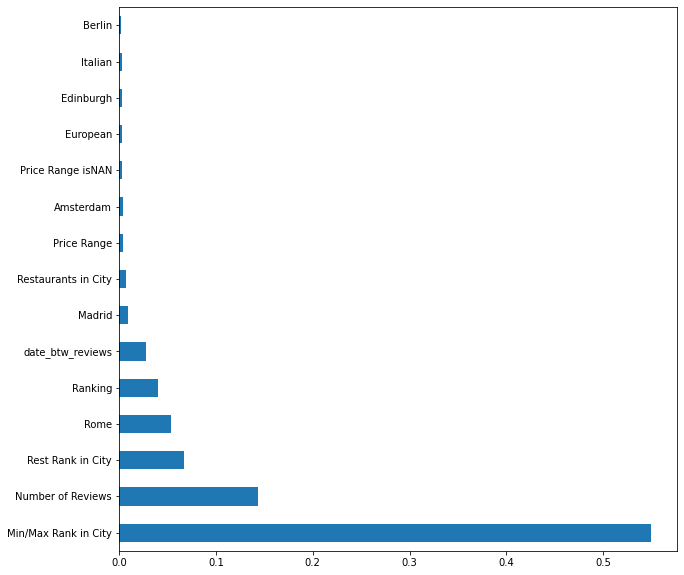

In [17]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [18]:
test_data.sample(10)

,Ranking,Price Range,Number of Reviews,Rating,Number of Reviews isNAN,Price Range isNAN,Madrid,Berlin,London,Luxembourg,...,Korean,Pizza,African,Austrian,Spanish,Healthy,Restaurants in City,Rest Rank in City,Min/Max Rank in City,date_btw_reviews
9355,5037.0,20,14.0,0.0,0,0,0,0,1,0,...,0,0,0,0,0,0,7193,0.70,0.69,11.0
6186,4832.0,50,38.0,0.0,0,0,0,0,0,0,...,0,1,0,0,0,0,2589,1.87,0.19,8.0
2528,3867.0,50,90.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,6108,0.63,0.72,334.0
4302,9320.0,50,2.0,0.0,0,1,0,0,0,0,...,0,0,0,0,0,0,6108,1.53,0.33,14145.0
2882,808.0,50,8.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,590,1.37,0.43,124.0
6615,4585.0,50,20.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,6108,0.75,0.67,252.0
5007,2067.0,50,6.0,0.0,0,1,0,0,0,0,...,0,0,0,0,0,0,1033,2.00,0.16,223.0
9992,4425.0,50,53.0,0.0,0,0,0,0,1,0,...,0,0,0,0,0,0,7193,0.62,0.73,5.0
9651,2053.0,50,0.0,0.0,1,1,0,0,0,0,...,0,0,0,0,0,0,1186,1.73,0.25,0.0
8389,5161.0,50,16.0,0.0,0,0,0,0,1,0,...,0,0,0,0,0,0,7193,0.72,0.69,165.0


In [19]:
test_data = test_data.drop(['Rating'], axis=1)

In [20]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [21]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [22]:
predict_submission

array([3.045, 4.225, 4.47 , ..., 3.16 , 4.495, 4.3  ])

In [23]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.045
1,id_1,4.225
2,id_2,4.470
3,id_3,4.320
4,id_4,4.505
5,id_5,4.485
6,id_6,2.080
7,id_7,3.575
8,id_8,4.225
9,id_9,4.615
